In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using:', device)

using: cpu


In [3]:
# Architectures
    
class GlyNet(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super(GlyNet, self).__init__()
        self.fc1 = nn.Linear(in_dim, hid_dim)
        self.fc2 = nn.Linear(hid_dim, out_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [4]:
# Data

def get_data(choice=None):
    """Get IUPAC, fingerprint and log RFU data.
    choice: Choice of sample. If None, all samples used. Default: None"""
    iupac_data = pd.read_csv('Data/IUPAC.csv').dropna()
    iupacs = iupac_data['IUPAC'].tolist()
    fingpr_data = pd.read_csv('Data/Fingerprints.csv')
    fingpr_data = fingpr_data.drop('IUPAC', axis=1)
    fingprs = fingpr_data.values.tolist()
    rfu_data = pd.read_csv('Data/Avg. RFU.csv').dropna()
    rfu_data = rfu_data.drop('Index', axis=1).apply(log)
    rfu_data = rfu_data[[choice]] if choice else rfu_data
    rfus = rfu_data.values.tolist()
    data = list(zip(iupacs, fingprs, rfus))
    samples = rfu_data.columns.tolist()
    in_dim = len(fingpr_data.columns)
    out_dim = len(rfu_data.columns)
    return data, samples, in_dim, out_dim

def prepare_data(data):
    """Prepare inputs and desired outputs for training."""
    fingpr_tensors, rfu_tensors = [], []
    for iupac, fingpr, rfu in data:
        fingpr_tensor = torch.tensor(fingpr).float().to(device)
        rfu_tensor = torch.tensor(rfu).float().to(device)
        fingpr_tensors.append(fingpr_tensor)
        rfu_tensors.append(rfu_tensor)
    trainset = list(zip(fingpr_tensors, rfu_tensors))
    return torch.utils.data.DataLoader(trainset, batch_size=64)

In [5]:
# Functions

def log(values):
    """Log base 10."""
    return np.log10(values - values.min() + 1)

def z_score(values):
    """Z-Score from Mean Absolute Deviation."""
    diff = values - values.median()
    mad = diff.abs().median()
    return (0.6745 * (diff)) / mad

In [6]:
# Training

def early_stop(losses, patience):
    """Return True if the loss hasn't improved for a number of epochs.
    patience: Number of epochs without improvement."""
    if min(losses) < min(losses[-patience:]):
        return True

def train_full(n_hidden=800, patience=10, choice=None, plot=False):
    """Train GlyNet on the complete CFG data for making predictions.
    n_hidden: Number of neurons in a hidden layer. Default: 800
    patience: Number of epochs without improvement. Default: 10
    choice: Choice of sample. If None, all samples used. Default: None
    plot: Plot loss for every epoch. Default: False"""
    data, samples, in_dim, out_dim = get_data(choice)
    net = GlyNet(in_dim, n_hidden, out_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), weight_decay=1e-4)
    trainloader = prepare_data(data)
    train_losses = []
    for epoch in range(1000):
        batch_loss = 0.0
        for inputs, values in trainloader:
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(values, outputs)
            loss.backward()
            optimizer.step()
            batch_size, _ = values.size()
            batch_loss += loss.item() * batch_size
        train_loss = batch_loss / len(data)
        train_losses.append(train_loss)
        if early_stop(train_losses, patience):
            break
    print('GlyNet Training Complete')
    if plot:
        plot_performance(train_losses)
    for param in net.parameters():
        param.requires_grad = False
    return net

In [7]:
# Visuals

def plot_performance(train_losses):
    """Plots training loss."""
    plt.plot(train_losses, label = 'Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(alpha=0.2)
    plt.legend()
    plt.show()

def plot_predictions(novel_data, sample, color, filename=None):
    """Plot predictions for novel glycans.
    filename: Saves plot if a filename is given. Default: None"""
    sample_data = novel_data[sample].copy()
    sample_data = sample_data.reset_index(drop=True)
    plt.figure(figsize=(20, 5))
    threshold = sample_data[z_score(sample_data) < 3.5].max()
    if not threshold is np.nan:
        binder = sample_data[sample_data > threshold]
        nonbinder = sample_data[sample_data < threshold]
        plt.scatter(binder.index, binder.values, color=color, alpha=0.8, label='Prediction for Binder')
        plt.scatter(nonbinder.index, nonbinder.values, color=color, alpha=0.3, label='Prediction for Non-Binder')
    else:
        plt.scatter(sample_data.index, sample_data.values, color=color, alpha=0.3, label='Predictions (No Threshold)')
    plt.title(sample, fontweight='bold')
    plt.xlabel('Novel Glycans')
    plt.ylabel('Log RFU')
    plt.grid(alpha=0.2)
    plt.legend()
    plt.savefig(filename, bbox_inches='tight') if filename else plt.show()

In [8]:
# Results

def get_predictable(results, cutoff=0.5):
    """Get the samples with the highest performace during cross-validation.
    cutoff: Use samples below the cutoff MSE+(1-R2). Default: 0.5"""
    info_data = pd.read_csv('Data/Information.csv')
    results['cbpId'] = info_data['cbpId']
    results = results[results['MSE+(1-R2)'] < cutoff]
    cbp_dict = {}
    for cbpId in sorted(set(results['cbpId'])):
        cbp_data = results[results['cbpId'] == cbpId]
        cbp_data = cbp_data.sort_values('MSE+(1-R2)')
        cbp_dict[cbpId] = cbp_data['Sample'].tolist()
    return cbp_dict

def get_novel_data(plot=False):
    """Make predictions on novel glycans using the fully trained model."""
    net = train_full(plot=plot)
    novel_fingprs = pd.read_csv('GlyGen/Fingerprints.csv')
    novel_inputs = torch.tensor(novel_fingprs.iloc[:, 1:].values).float()
    novel_outputs = net(novel_inputs)
    novel_data = pd.DataFrame(novel_outputs.numpy(),
        columns=results['Sample'], index=novel_fingprs['IUPAC'])
    return novel_data

def get_binders(novel_data, sample, threshold=3.5):
    """Get glycans that are predicted to bind."""
    values = novel_data[sample]
    m = z_score(values)
    binders = values[m > threshold].index.tolist()
    return binders

In [14]:
novel_data = get_novel_data(plot=False)
novel_data.to_csv('Results/Novel Data.csv')

GlyNet Training Complete


In [13]:
results = pd.read_csv('Results/Metrics.csv')
predictable = get_predictable(results, cutoff=0.4)
print(len(predictable), 'Unique CBPs Ready for Prediction:', '\n')
for cbp in predictable:
    samples = predictable[cbp]
    print(*sorted(samples), sep=', ')

13 Unique CBPs Ready for Prediction: 

WT-VCC (180ug/ml)
LSL-150 0.2ug/ml, LSL-150 2ug/ml
LBL-152 0.2ug/ml, LBL-152 2ug/ml
AAL (0.1ug/ml), AAL (100 ug/ml)
ConA (1ug/ml), ConA (50ug/ml), ConA (5ug/ml)
LCA (100 ug/ml), LCA (10ug/ml), LCA (1ug/ml)
PHA-E (100ug/ml), PHA-E (10ug/ml)
PSA 100ug/ml, PSA 10ug/ml
CA 100ug/ml
LcH (10ug/ml)
AOL (Mahal Lab) (0.1ug/ml)
ConA 0.5ug/ml, ConA 100ug/ml , ConA 10ug/ml, ConA 1ug/ml, ConA 50ug/ml
WT (50ug/ml)


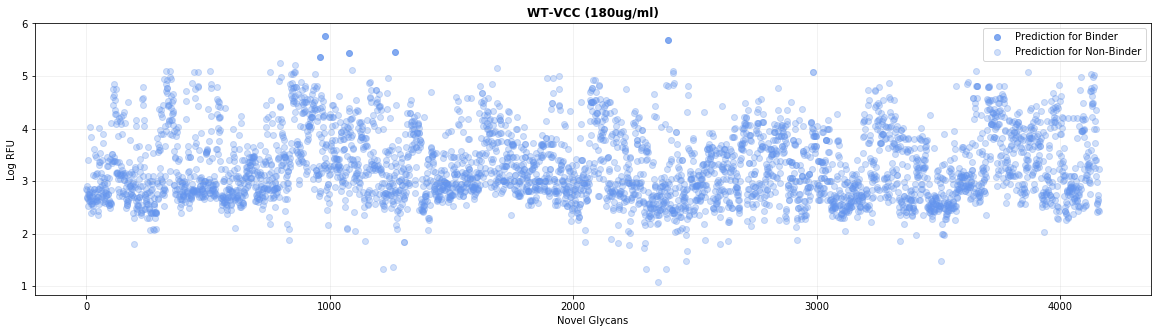

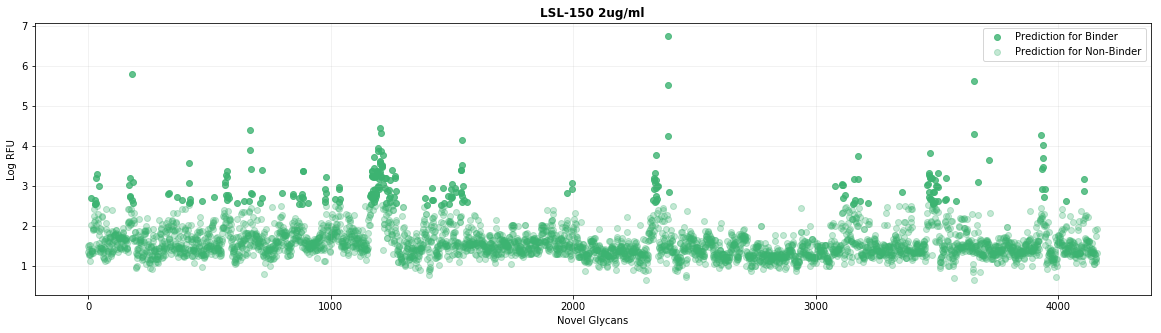

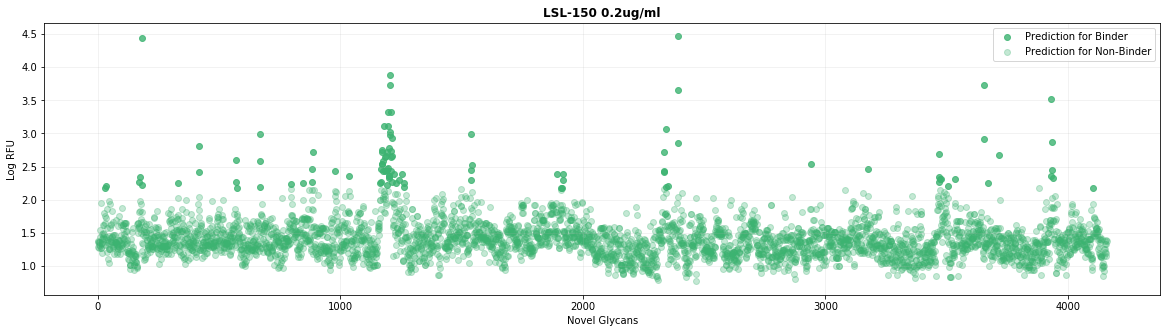

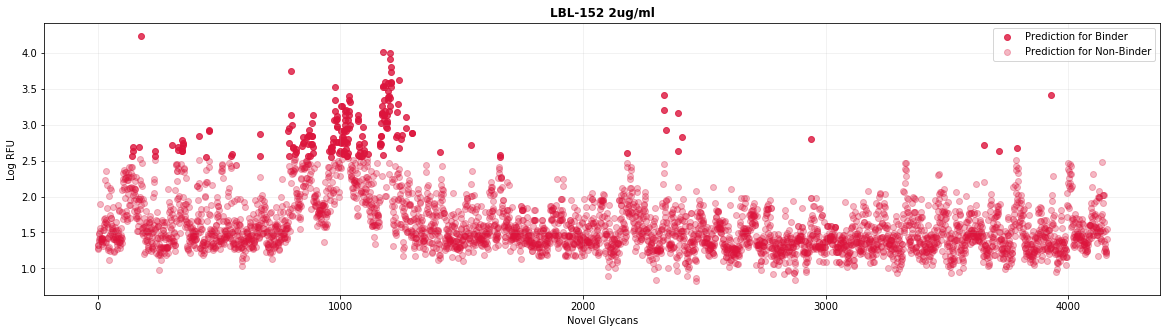

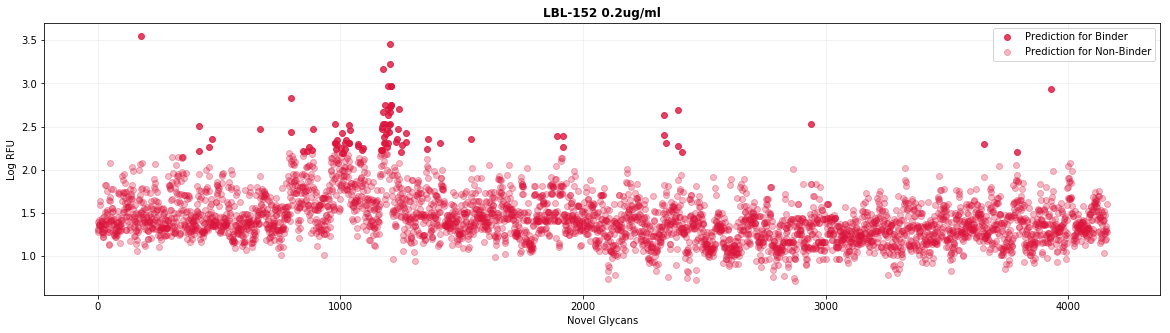

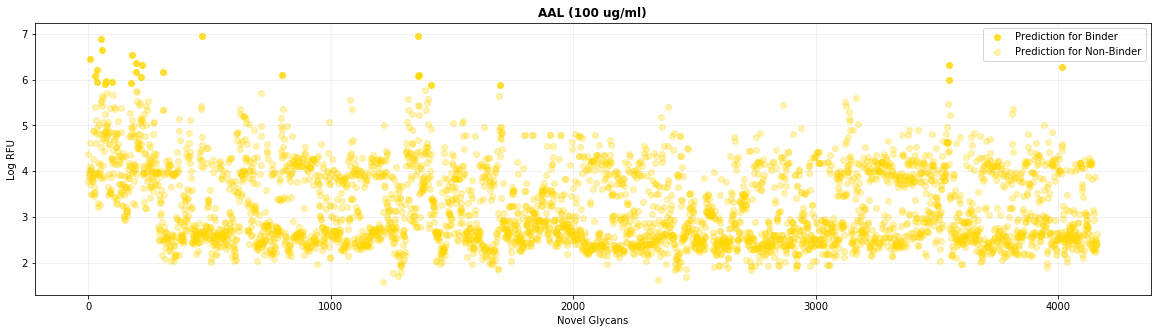

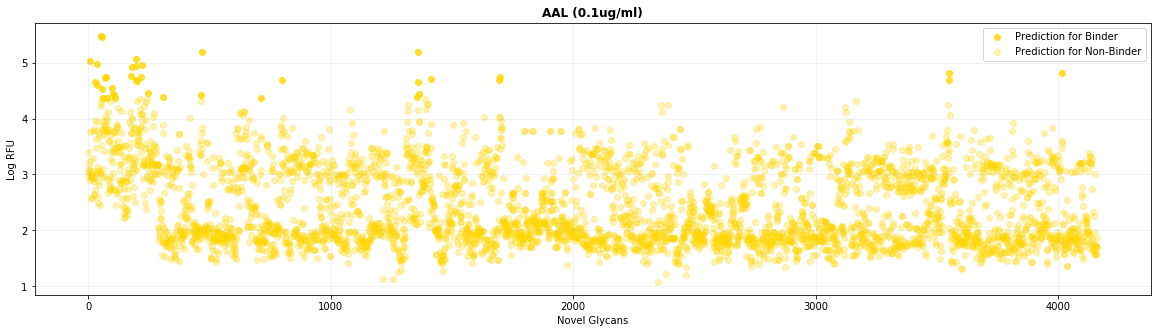

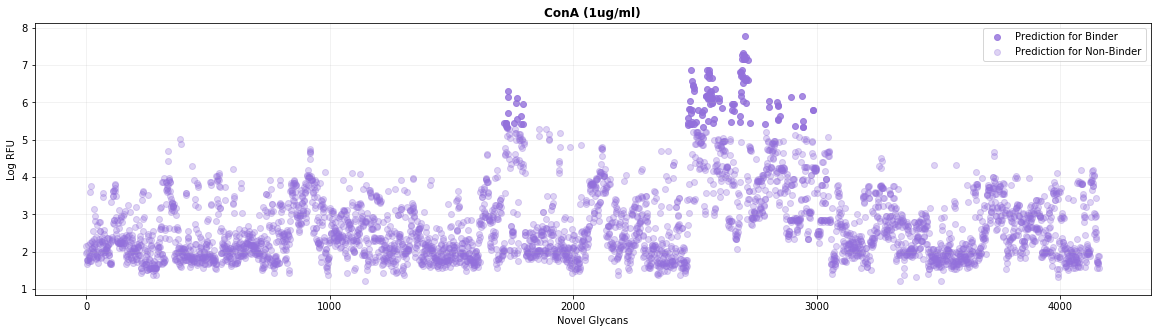

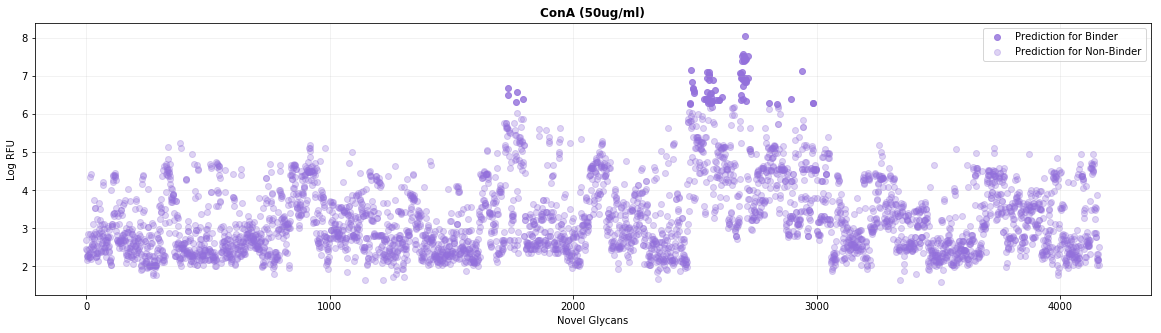

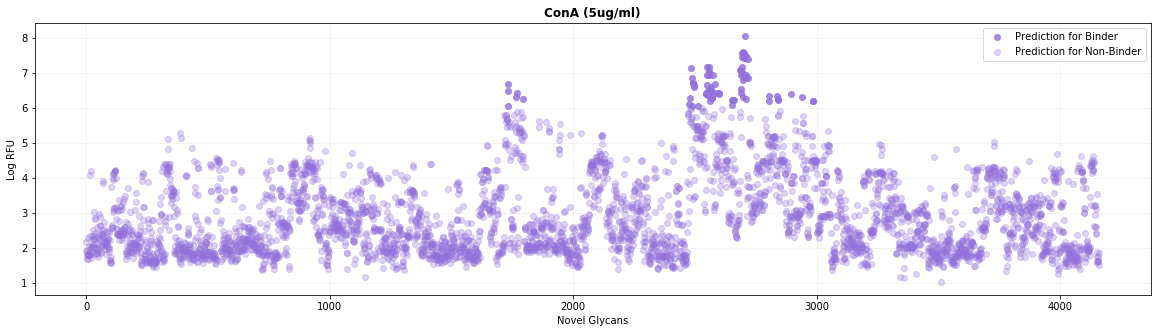

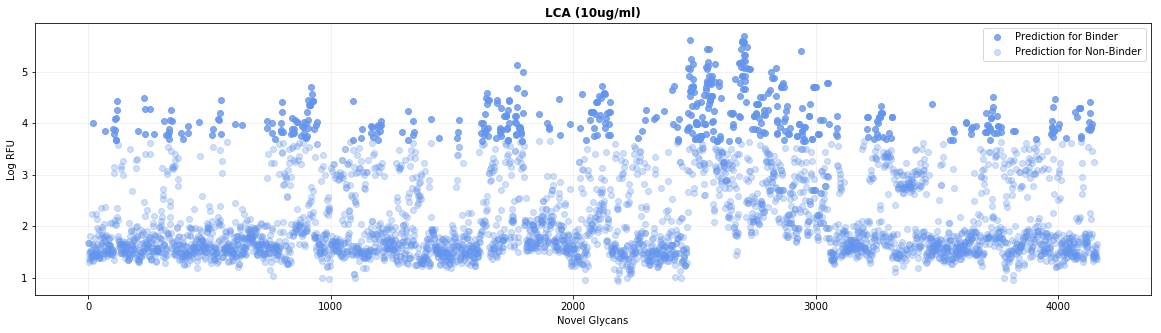

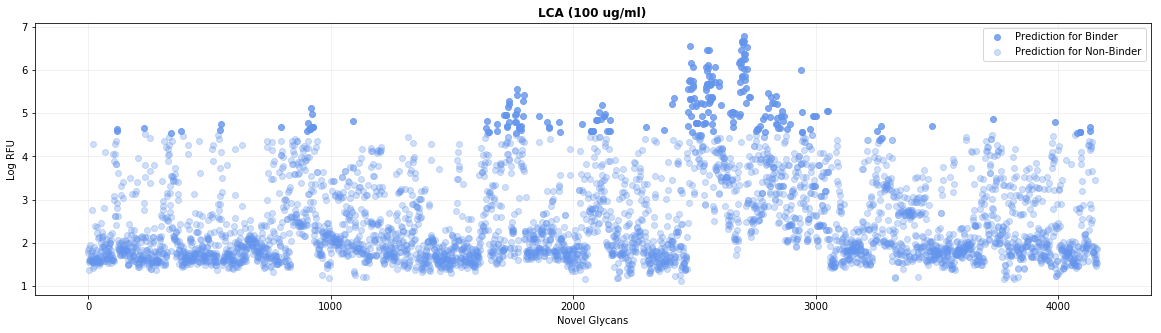

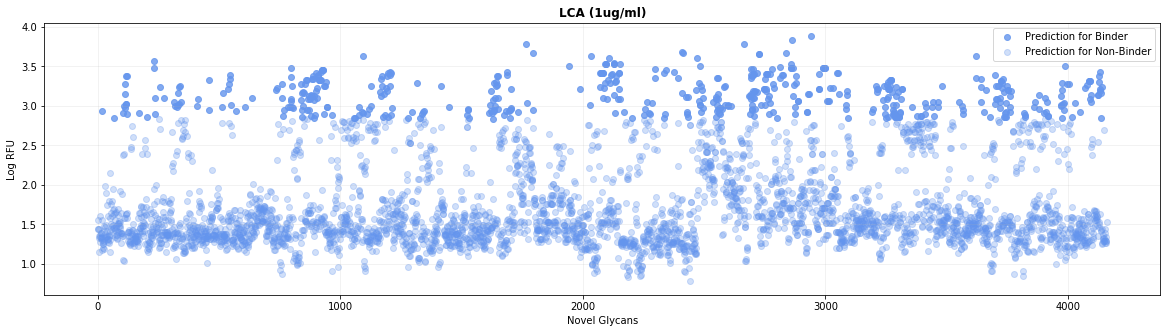

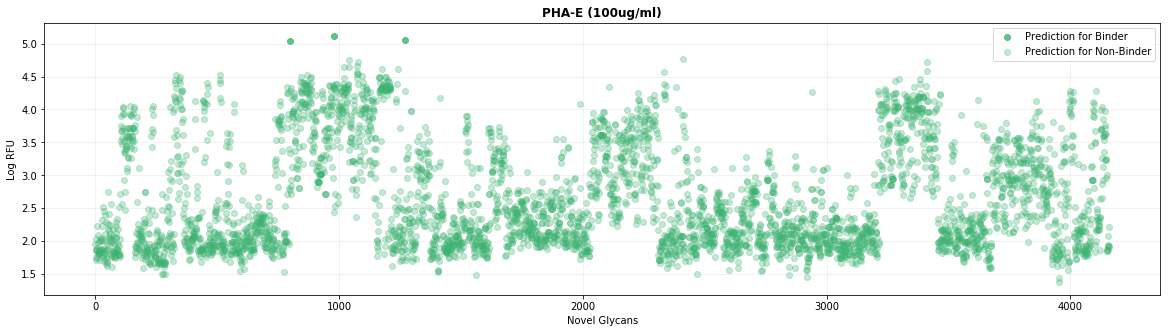

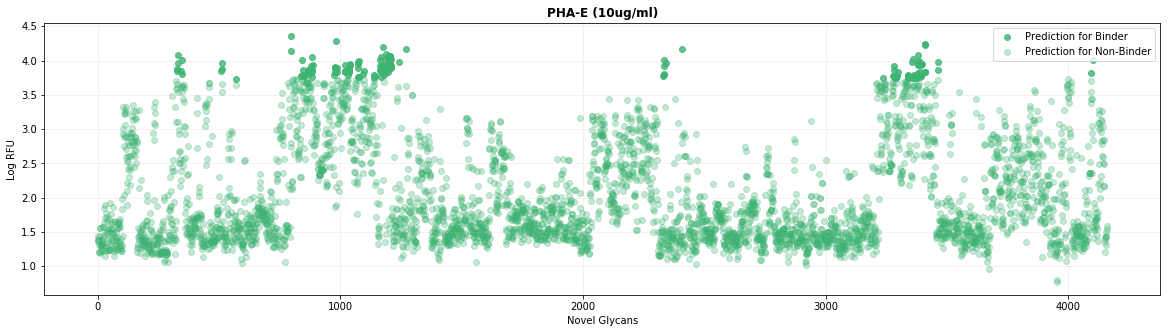

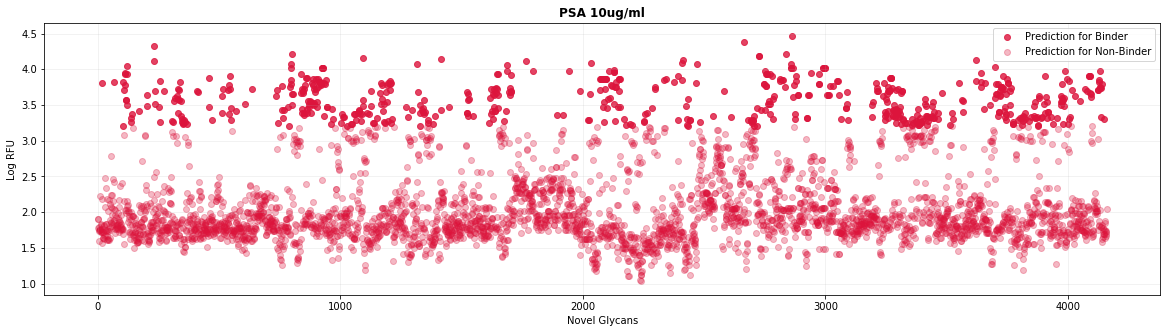

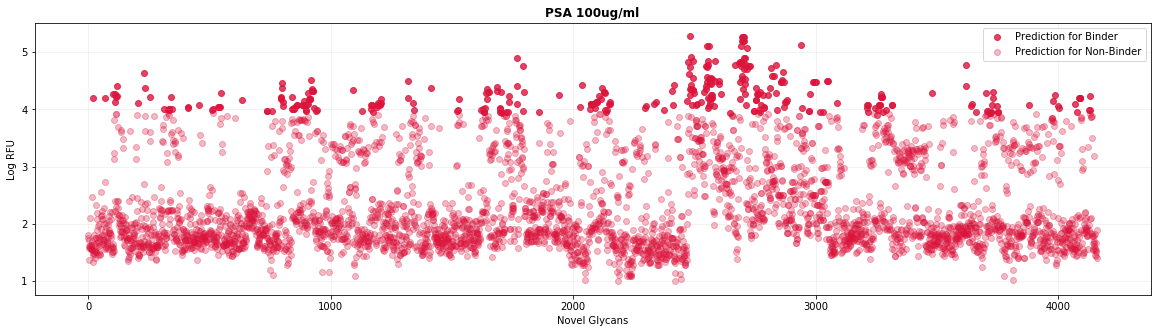

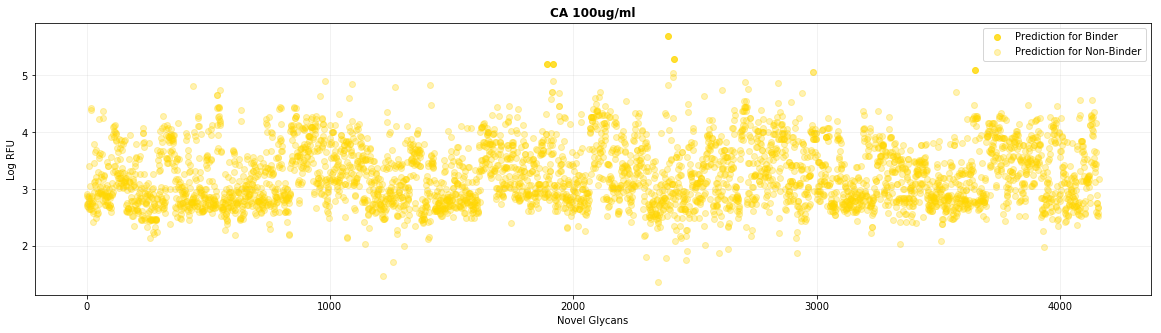

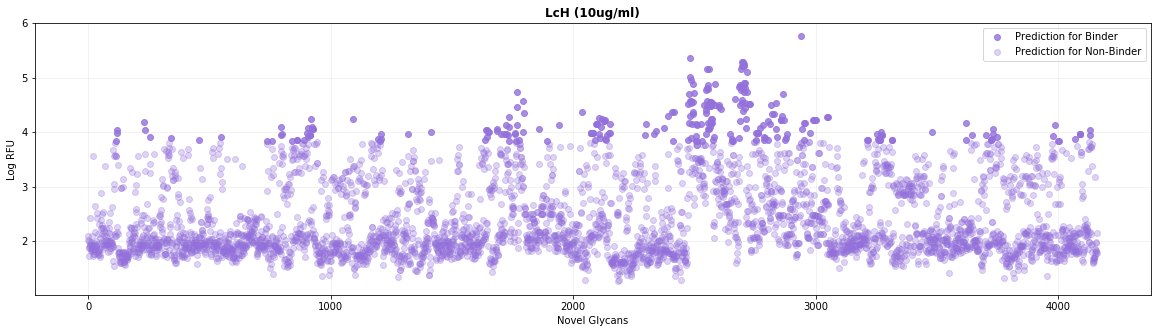

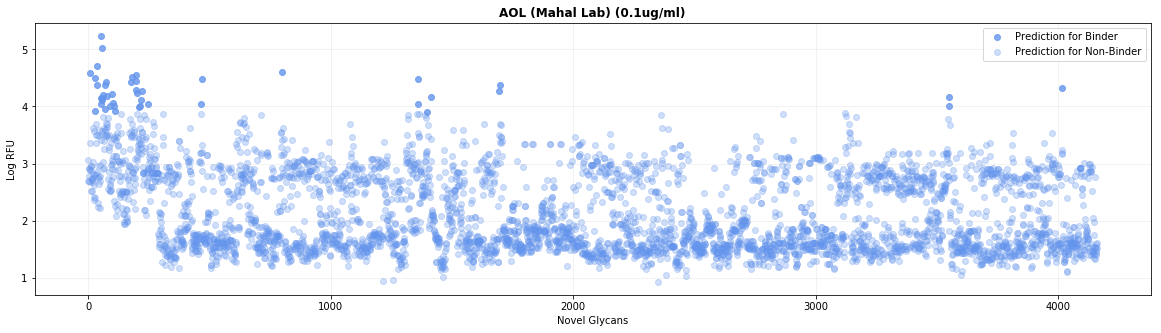

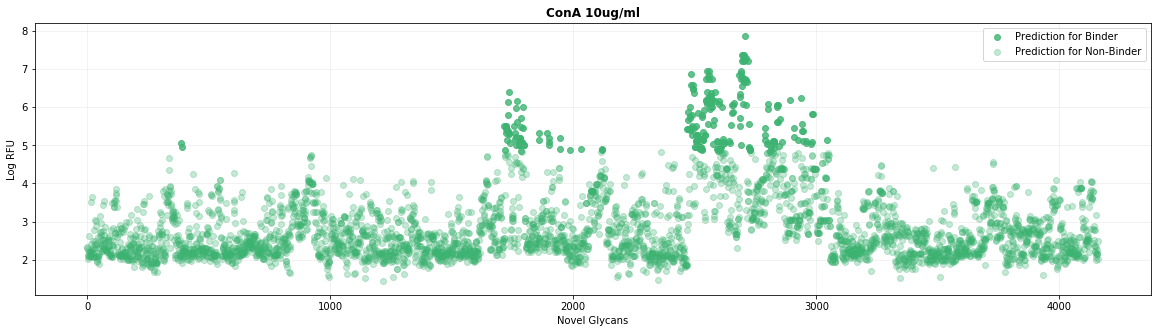

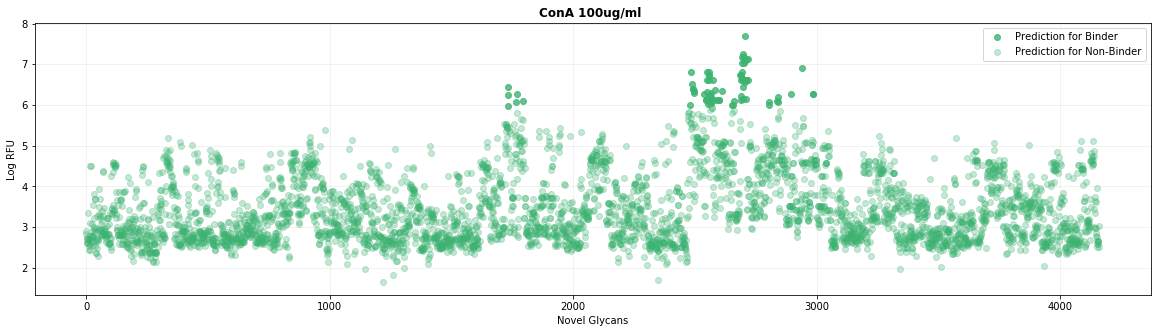

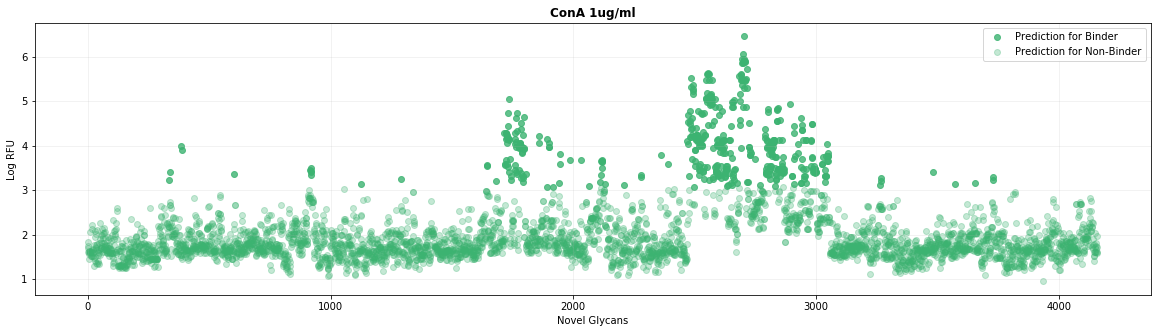

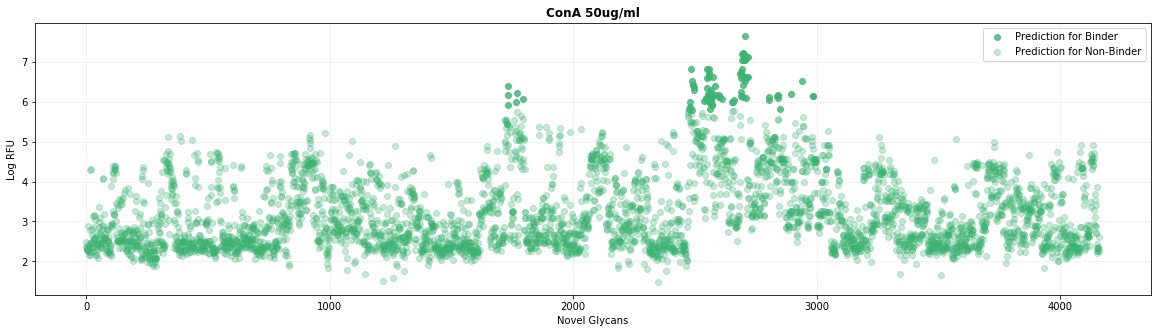

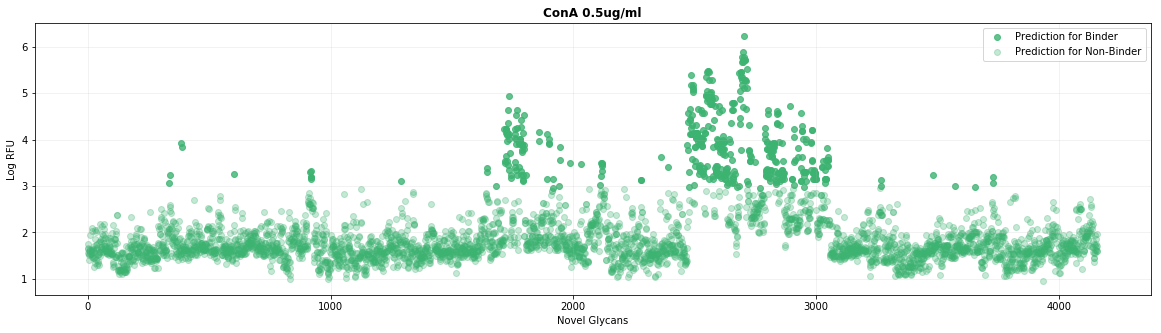

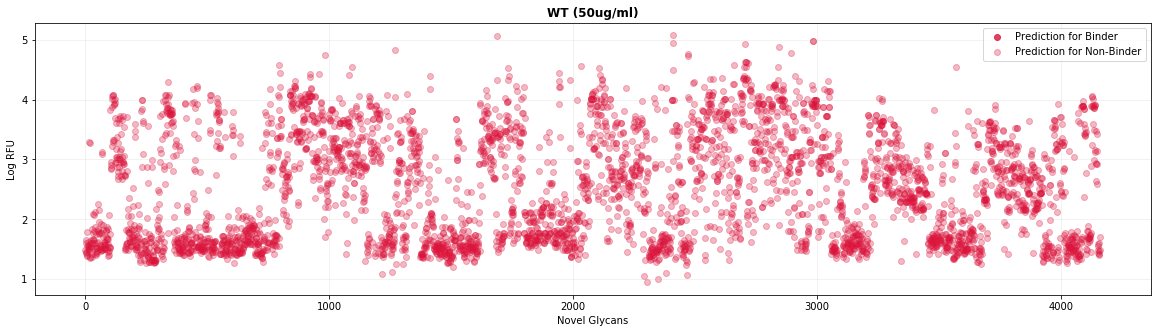

In [15]:
colors = ['cornflowerblue', 'mediumseagreen', 'crimson', 'gold', 'mediumpurple'] * 114
for i, cbpId in enumerate(predictable):
    for sample in predictable[cbpId]:
        plot_predictions(novel_data, sample, colors[i])